In [1]:
import numpy as np
import cv2
import sys
import glob
from matplotlib import pyplot as plt

In [2]:
# training data
dataset_path = "dataset/image/design1/*.jpg"
files = glob.glob(dataset_path) 

In [3]:
# test data
test_path = "dataset/image/real/*.png"
# test_path = "dataset/image/design1/*.jpg"
test_files = glob.glob(test_path) 

In [4]:
ksize = 7

In [5]:
# noise removal
def remove_noise(image, k):
    return cv2.GaussianBlur(image,(k,k),0)
    # return cv2.medianBlur(image,k)


#thresholding_otsu
def thresholding_otsu(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#thresholding
def thresholding(image):
    # return cv2.threshold(image,0, 100, cv2.THRESH_BINARY)[1]
    return cv2.adaptiveThreshold(image,                        # 8-bit 1-channel
                                255,                        # max value
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY,
                                ksize,                      # kernel size
                                2 )                         # C constant

#dilation
def dilate(image, cnt_dilate):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = cnt_dilate)
    
#erosion
def erode(image, cnt_erode):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = cnt_erode)

#closing
def closing(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

#opening
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 255)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)


In [24]:
def get_mark(dir):
    img = cv2.imread(dir)
    print( 'img',img.shape )
    # resize
    h, w, _= img.shape
    if h > w:
        img = cv2.resize(img,(150, round(150 * h / w) ))        
    else:
        img = cv2.resize(img,(round(150 * w / h),150))
    print( 'img-resize',img.shape )
    # rgb for present
    img_org = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # gray
    img_gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    img_gray = remove_noise(img_gray, 3)
    
    img_candy = canny(img_gray)

    # Find all contours
    contours, hierarchy = cv2.findContours(img_candy,
                                          cv2.RETR_LIST,
                                          cv2.CHAIN_APPROX_NONE)

    contours_mark = []
    max_area = 0
    max_length = 0
    img_box = img.copy()
    for c in contours:
        if cv2.contourArea(c) > max_area:
            max_area = cv2.contourArea(c)
        if cv2.arcLength(c,False) > max_length:
            max_length = cv2.arcLength(c,False)
        if (cv2.contourArea(c) > 900 ) or (cv2.arcLength(c,False) > 500 ):
            contours_mark.append(c)
            x,y,w,h = cv2.boundingRect(c)
            print('w,h',w,h, w/h)
            is_square = False
            
            if w/h > 0.8 and w/h < 1.2:
                is_square = True
            if is_square:
                cv2.rectangle(img_box,(x,y),(x+w,y+h),(0,255,0),2)
        # print(cv2.contourArea(c),cv2.arcLength(c,False))
    print('max', max_area, max_length)

    mark_object = cv2.drawContours( img_org.copy(),contours_mark,-1, 
                  (0,255,0), 
                  thickness=2)
                  
    # img_object = mark_object
    # title
    titles = [ 'img_org',  'img_gray','img_candy','mark_object','img_box']
    images = [ img_org,  img_gray ,img_candy,mark_object,img_box]

    # Show all resultant images using pyplot
    fig = plt.figure(figsize=(15,8))
    fig.canvas.set_window_title('OpenCV')
    for i in range(len(titles)):
        plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

img (167, 117, 3)
img-resize (214, 150, 3)
w,h 41 65 0.6307692307692307
w,h 41 65 0.6307692307692307
w,h 102 98 1.0408163265306123
max 1117.0 556.9453008174896
img (532, 186, 3)
img-resize (429, 150, 3)
w,h 60 24 2.5
w,h 61 24 2.5416666666666665
w,h 55 48 1.1458333333333333
w,h 150 206 0.7281553398058253
w,h 98 117 0.8376068376068376
w,h 98 117 0.8376068376068376
max 5764.0 2132.545367836952
img (685, 257, 3)
img-resize (400, 150, 3)
w,h 34 263 0.12927756653992395
w,h 113 108 1.0462962962962963
w,h 113 108 1.0462962962962963
w,h 56 136 0.4117647058823529
max 9946.0 641.6101716756821
img (258, 132, 3)
img-resize (293, 150, 3)
w,h 34 158 0.21518987341772153
w,h 51 60 0.85
w,h 51 60 0.85
w,h 123 119 1.0336134453781514
w,h 128 119 1.0756302521008403
w,h 2 282 0.0070921985815602835
max 7525.0 564.3137083053589
img (310, 102, 3)
img-resize (456, 150, 3)
w,h 31 84 0.36904761904761907
w,h 48 128 0.375
max 332.0 550.9898953437805
img (226, 101, 3)
img-resize (336, 150, 3)
max 84.5 352.325900912

/var/folders/81/801rlldj66b9mqn09r7s37jr0000gn/T/ipykernel_15252/4254636046.py:57: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('OpenCV')


img (86, 99, 3)
img-resize (150, 173, 3)
w,h 91 92 0.9891304347826086
max 489.5 559.192993760109
img (125, 127, 3)
img-resize (150, 152, 3)
w,h 30 43 0.6976744186046512
w,h 117 114 1.0263157894736843
w,h 117 114 1.0263157894736843
w,h 128 123 1.0406504065040652
w,h 128 123 1.0406504065040652
max 12779.5 416.74725472927094
img (333, 127, 3)
img-resize (393, 150, 3)
w,h 78 191 0.4083769633507853
w,h 77 66 1.1666666666666667
w,h 77 66 1.1666666666666667
w,h 81 79 1.0253164556962024
w,h 33 44 0.75
w,h 115 112 1.0267857142857142
w,h 115 112 1.0267857142857142
w,h 126 120 1.05
w,h 126 120 1.05
max 12364.0 636.6883796453476
img (182, 624, 3)
img-resize (150, 514, 3)
w,h 405 39 10.384615384615385
w,h 76 41 1.853658536585366
w,h 71 67 1.0597014925373134
w,h 45 60 0.75
w,h 36 76 0.47368421052631576
w,h 71 57 1.2456140350877194
w,h 280 107 2.616822429906542
max 2292.0 4868.559983491898


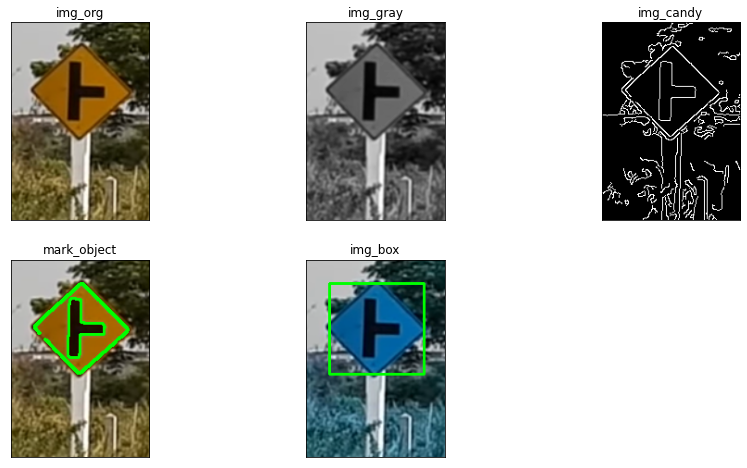

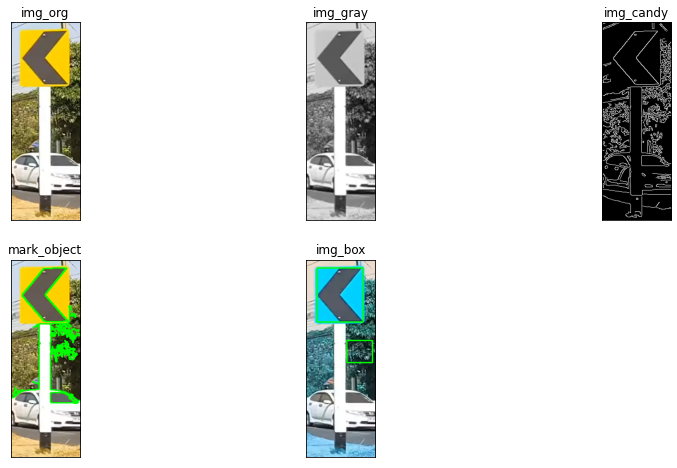

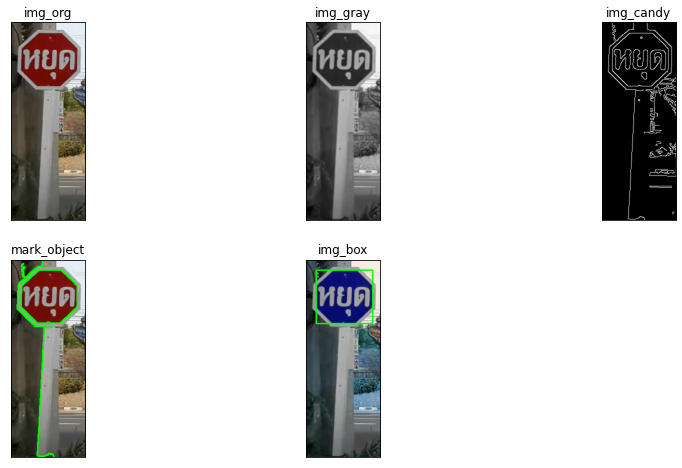

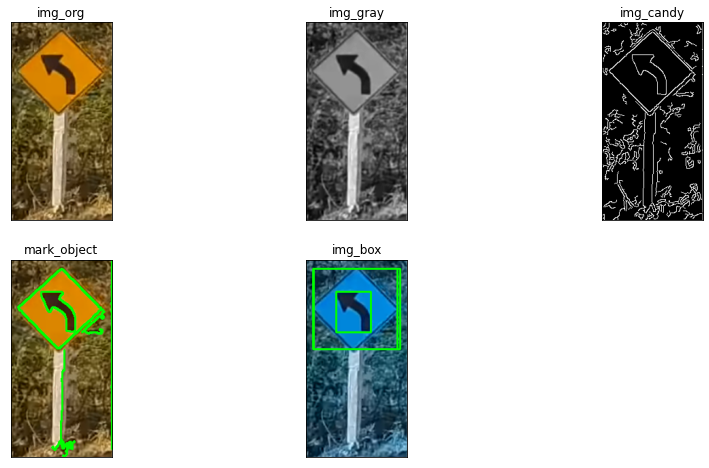

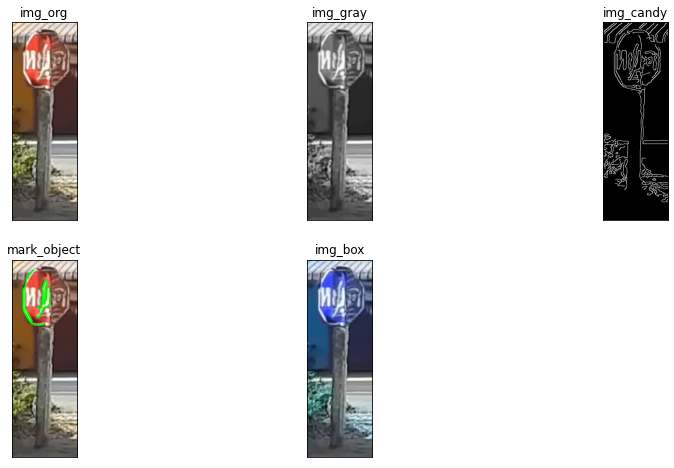

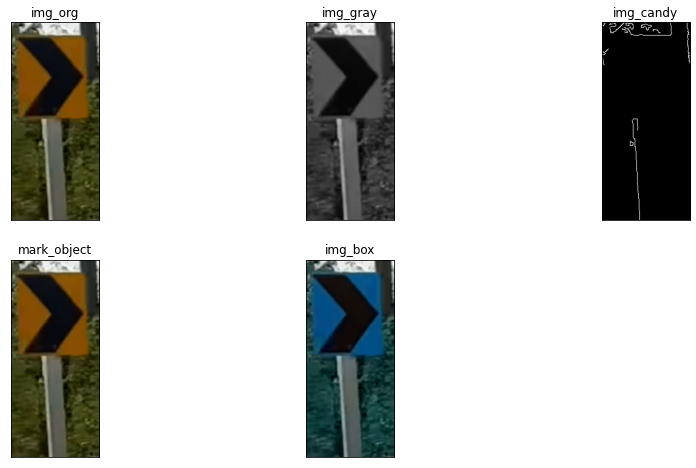

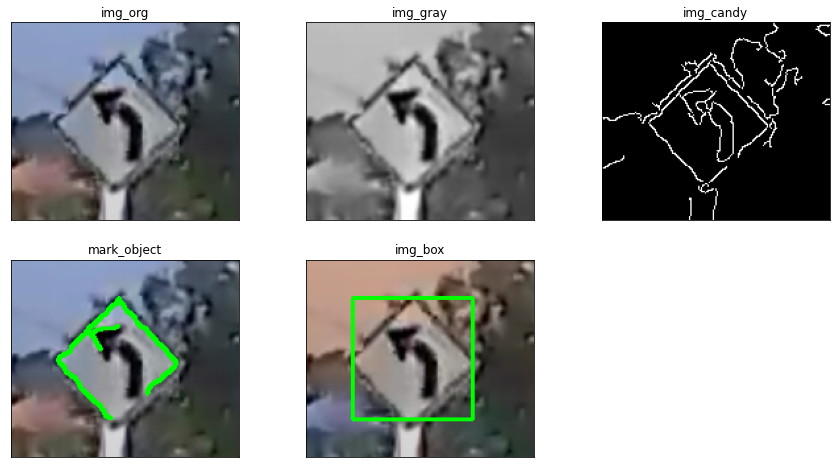

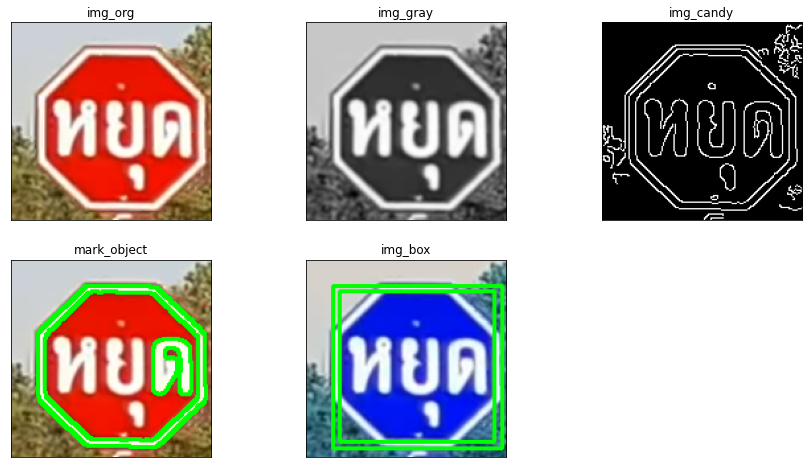

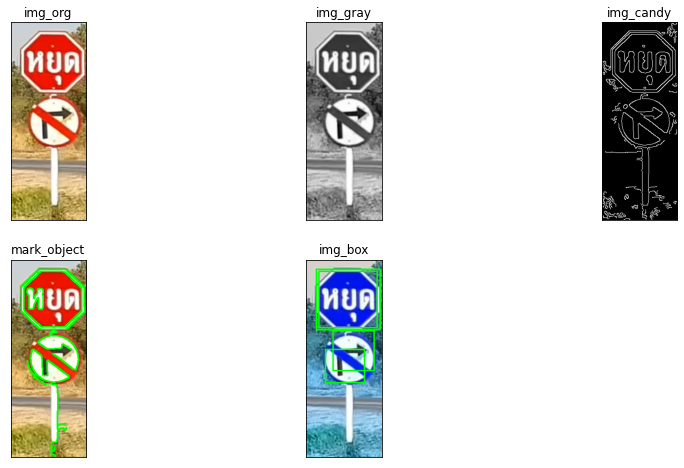

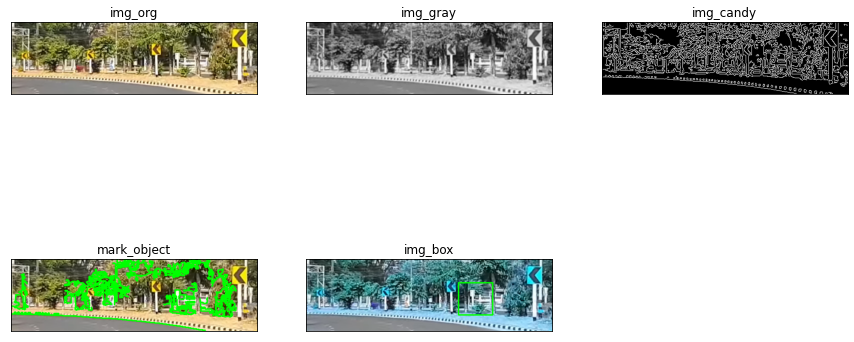

In [25]:
for item in test_files[:10]:
    try:
        get_mark(item)
    except:
        print(item)